# Richards model prediction of Covid-19 for Spain

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # plots
import pymc3 as pm
import arviz as az

# Source: https://es.wikipedia.org/wiki/ISO_3166-2:ES
map_code_name = {'AN': 'Andalucia', 'AR': 'Aragon', 'AS': 'Principado_de_Asturias',
                 'CN': 'Canarias', 'CB': 'Cantabria', 'CM': 'Castilla_La_Mancha',
                 'CL': 'Castilla_y_Leon', 'CT': 'Catalunya', 'EX': 'Extremadura',
                 'GA': 'Galicia', 'IB': 'Illes_Balears', 'RI': 'La_Rioja',
                 'MD': 'Comunidad_de_Madrid', 'MC': 'Region_de_Murcia', 
                 'NC': 'Comunidad_Foral_de_Navarra', 'PV': 'Pais_Vasco', 
                 'VC': 'Comunidad_Valenciana', 'CE': 'Ceuta', 'ML': 'Melilla'}

In [26]:
# Source: https://covid19.isciii.es/
df_input = pd.read_csv('data/agregados.csv', sep=',', decimal='.',
                       error_bad_lines=False, encoding='ISO-8859-15',dtype='object')
df_input.columns = df_input.columns.map(lambda x: str(x).lower()) 
df_input = df_input[df_input['ccaa'].map(lambda x: len(str(x))<3)]
df_input['ccaa_name'] = df_input['ccaa'].map(map_code_name)
df_input['fecha'] = pd.to_datetime(df_input['fecha'], format='%d/%m/%Y')
df_input = df_input.fillna(0)
cols_num = ['casos','pcr+', 'testac+','hospitalizados','uci','fallecidos','recuperados']
for v in cols_num:
    df_input[v] = df_input[v].astype(float)
df_input['casos'] = df_input['casos'] + df_input['pcr+'] + df_input['testac+']
df_input.tail(5)

,ccaa,fecha,casos,pcr+,testac+,hospitalizados,uci,fallecidos,recuperados,ccaa_name
1648,ML,2020-05-16,134.0,121.0,13.0,44.0,3.0,2.0,124.0,Melilla
1649,MC,2020-05-16,2566.0,1551.0,1015.0,676.0,112.0,144.0,2084.0,Region_de_Murcia
1650,NC,2020-05-16,8293.0,5148.0,3145.0,2045.0,136.0,503.0,3751.0,Comunidad_Foral_de_Navarra
1651,PV,2020-05-16,18733.0,13407.0,5326.0,7015.0,578.0,1459.0,16028.0,Pais_Vasco
1652,RI,2020-05-16,5417.0,4024.0,1393.0,1496.0,91.0,349.0,3048.0,La_Rioja


In [27]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1653 entries, 0 to 1652
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ccaa            1653 non-null   object        
 1   fecha           1653 non-null   datetime64[ns]
 2   casos           1653 non-null   float64       
 3   pcr+            1653 non-null   float64       
 4   testac+         1653 non-null   float64       
 5   hospitalizados  1653 non-null   float64       
 6   uci             1653 non-null   float64       
 7   fallecidos      1653 non-null   float64       
 8   recuperados     1653 non-null   float64       
 9   ccaa_name       1653 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 142.1+ KB


In [28]:
df_pop = pd.read_csv('data/spain_population_ccaa.csv', sep=',', decimal='.', header=None)
df_pop.columns = ['code','ccaa_name','population']
df_pop.head()

,code,ccaa_name,population
0,0,Total,47026208
1,1,Andalucia,8414240
2,2,Aragon,1319291
3,3,Principado_de_Asturias,1022800
4,4,Illes_Balears,1149460


In [6]:
df_pop[df_pop['ccaa_name']=='Principado_de_Asturias']['population']

3    1022800
Name: population, dtype: int64

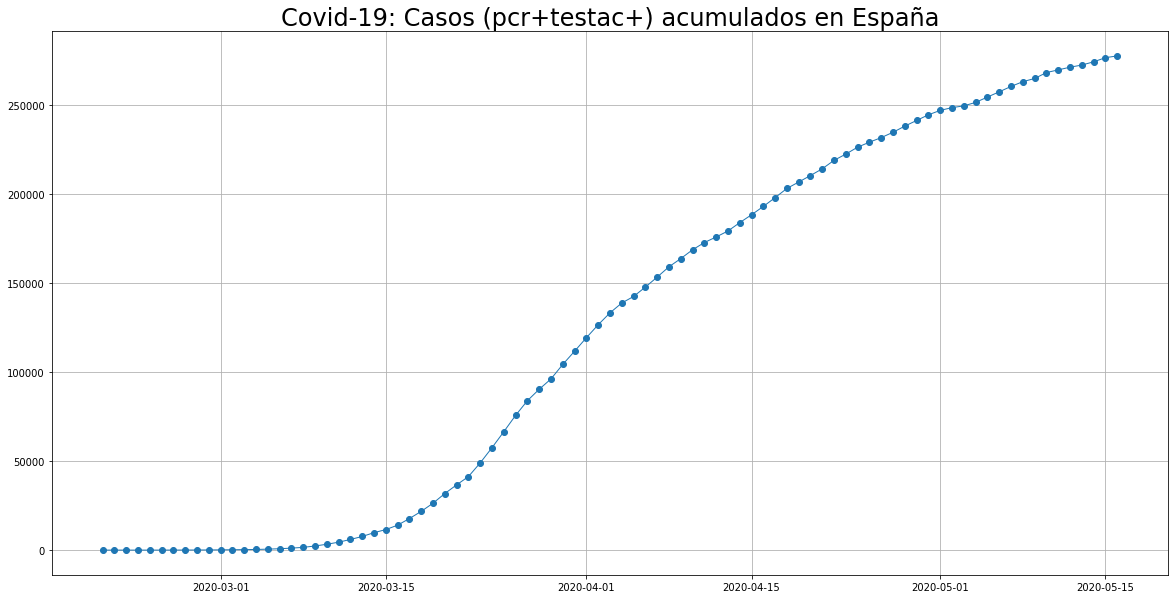

In [37]:
df_spain = df_input.groupby(['fecha'],as_index=False).agg({'casos':'sum'})
fig = plt.figure(figsize=(20,10))
plt.plot(df_spain['fecha'], df_spain['casos'], marker='o', ls='-', lw=1)
plt.title('Covid-19: Casos (pcr+testac+) acumulados en España', fontsize=24)
plt.grid()
plt.show()

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # plots
import pymc3 as pm
import arviz as az

# Global parameters
country = 'España'
ndays_limit = 74
epidemic_start = 100
x_data_label = 'days_since_{}'.format(epidemic_start)

# Prepare data for model training
df_spain.index = df_spain.fecha
df_spain['new_cases'] = df_spain['casos'] - df_spain['casos'].shift(1)
df = df_spain[df_spain['casos'] > epidemic_start][['fecha', 'casos', 'new_cases']].copy()
df.columns = ['date', 'acumulado', 'new_cases']
df[x_data_label] = list(np.arange(df.shape[0]))
print(df.head(5))
print(df.tail(5))

# split train and test
df_train = df.loc['2020-03-01':'2020-05-14']
df_test = df.loc['2020-05-15':'2020-05-16']
print(df_test)

                 date  acumulado  new_cases  days_since_100
fecha                                                      
2020-03-01 2020-03-01      138.0       55.0               0
2020-03-02 2020-03-02      195.0       57.0               1
2020-03-03 2020-03-03      270.0       75.0               2
2020-03-04 2020-03-04      352.0       82.0               3
2020-03-05 2020-03-05      535.0      183.0               4
                 date  acumulado  new_cases  days_since_100
fecha                                                      
2020-05-12 2020-05-12   271382.0     1519.0              72
2020-05-13 2020-05-13   272577.0     1195.0              73
2020-05-14 2020-05-14   274398.0     1821.0              74
2020-05-15 2020-05-15   276726.0     2328.0              75
2020-05-16 2020-05-16   277719.0      993.0              76
                 date  acumulado  new_cases  days_since_100
fecha                                                      
2020-05-15 2020-05-15   276726.0     232

In [43]:
x_values = df_train[x_data_label].values
y_values = df_train.acumulado.astype('float64').values
dt_until = str(df_train[df_train[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]).replace('-', '')
with pm.Model() as richards_model:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)
    K = pm.Uniform('K', 100, 1000000, testval=5000)  # carrying capacity
    rate = pm.Normal('rate', 0.3, 0.05, testval=0.45)  # growth rate
    a = pm.Uniform('a', 0.1, 10.0, testval=0.25)
    x0 = pm.Uniform('x0', 1, 200, testval=15)
    T = pm.Uniform('T', 1, 3, testval=1.2)
    R0 = pm.Deterministic('R0', np.exp(rate * T))

    # Create likelihood for data
    x_data = pm.Data("x_data", x_values)
    y_data = pm.Data("y_data", y_values)
    mu = K * (1 + np.exp(-rate * a * (x_data - x0 - (np.log(a) / (rate * a))))) ** (-1 / a)
    y = pm.Normal('y', mu=mu, tau=sigma, observed=y_data)
    
with richards_model:
    
    # Sample posterior
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(4000, tune=4000, cores=7, start=start, target_accept=.95, random_seed=1234)

logp = -773.2, ||grad|| = 1.6247: 100%|██████████| 64/64 [00:00<00:00, 2266.62it/s]           
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [T, x0, a, rate, K, sigma]
Sampling 7 chains, 0 divergences: 100%|██████████| 56000/56000 [01:28<00:00, 634.09draws/s]


In [45]:
# Fitted parameters
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
txt = """
        --------------------------------------
        Fitted parameters for {}:
        --------------------------------------
        Growth rate: {}
        Turning point: {}
        Final size of epidemic: {}
        Basic reproduction number (R0): {}
        --------------------------------------
     """.format(country, *f_values)
print(txt)

# ========== Compute predictions =============
np.random.seed(12345)
tp = int(round(np.percentile(trace['x0'], 50, axis=0)))
h = tp # 27  # number points to prediction ahead
with richards_model:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, len(y_values) + h)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({"x_data": x_data})
    pm.set_data({"y_data": y_data})

    # Sample posterior predictive
    post_pred_final = pm.sample_posterior_predictive(trace, samples=100)

# Prediction of cumulative cases 
y_min_final = np.percentile(post_pred_final['y'], 2.5, axis=0)
y_max_final = np.percentile(post_pred_final['y'], 97.5, axis=0)
y_fit_final = np.percentile(post_pred_final['y'], 50, axis=0)

# Prediction of incidence of new cases
dy_fit_final = np.percentile(trace['rate'], 50, axis=0) * y_fit_final * (1 - (y_fit_final / np.percentile(trace['K'], 50, axis=0)) ** np.percentile(trace['a'], 50, axis=0))

from sklearn.metrics import mean_squared_error
rms_train = round(np.sqrt(mean_squared_error(df_train['acumulado'], y_fit_final[df_train[x_data_label]])),2)
rms_test = round(np.sqrt(mean_squared_error(df_test['acumulado'], y_fit_final[df_test[x_data_label]])),2)
print('RMSE-train: {}'.format(rms_train))
print('RMSE-test: {}'.format(rms_test))

/home/jrd/.local/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
 14%|█▍        | 14/100 [00:00<00:00, 138.49it/s]


        --------------------------------------
        Fitted parameters for España:
        --------------------------------------
        Growth rate: 0.39
        Turning point: 31.18
        Final size of epidemic: 278147.6
        Basic reproduction number (R0): 2.25
        --------------------------------------
     


100%|██████████| 100/100 [00:00<00:00, 158.47it/s]

RMSE-train: 5484.63
RMSE-test: 10407.41


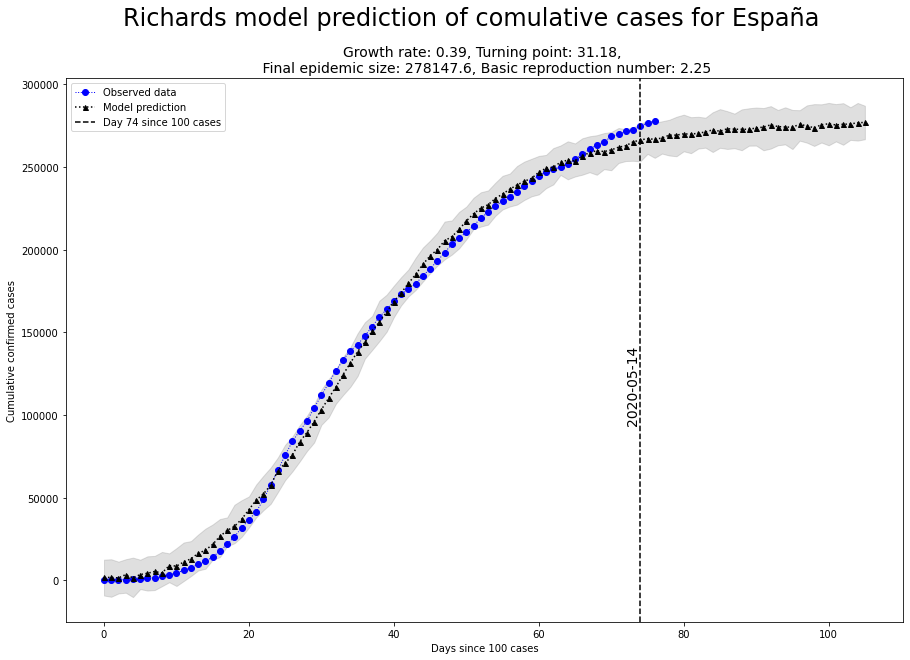

In [46]:
# Plot prediction of comulative cases
#ymax_limit = max(max(y_fit_final), df.acumulado.astype('float64').max()) * 1.10
yref_ycoord_0 = min(np.median(y_fit_final), df.acumulado.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['acumulado'], 'b', marker='o', ls=':', lw=1, label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), y_fit_final,
         'k', marker='^', ls=':', ms=5, mew=1, label='Model prediction')
plt.fill_between(np.arange(0, post_pred_final['y'].shape[1]), y_min_final, y_max_final, color='0.5', alpha=0.25)
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df_train[df_train[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
plt.suptitle('Richards model prediction of comulative cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
ax.set(xlabel='Days since {} cases'.format(epidemic_start))
ax.set(ylabel='Cumulative confirmed cases')
plt.legend(loc='upper left')
# plt.savefig('results/{}/cumulative_prediction_plot.png'.format(country))
plt.show()

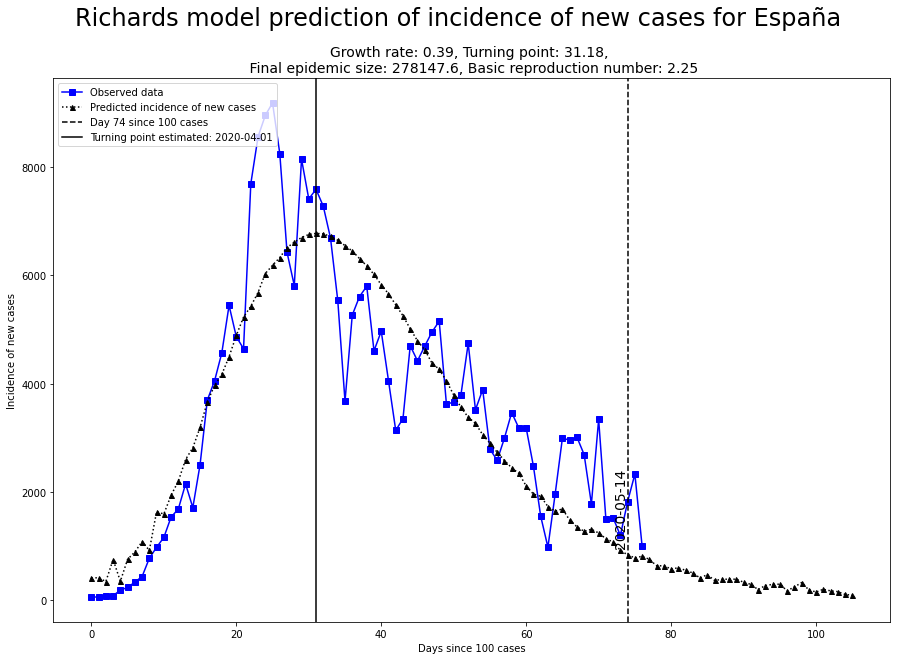

In [47]:
# Incidence of new cases prediction
yref_ycoord_0 = min(np.median(dy_fit_final), df.new_cases.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['new_cases'], 'b', marker='s', ls='-', label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), dy_fit_final, 'k', marker='^', ls=':', ms=5, mew=1,
         label='Predicted incidence of new cases')
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
if tp in list(df[x_data_label].values):
    tp_date = df[df[x_data_label] == tp].date.values[0]
    ax.axvline(tp, ls='-', color='k', label='Turning point estimated: {}'.format(str(tp_date)[:10]))
plt.xlabel('Days since {} cases'.format(epidemic_start))
plt.ylabel('Incidence of new cases')
plt.suptitle('Richards model prediction of incidence of new cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
plt.legend(loc='upper left')
# plt.savefig('results/{}/newcases_prediction_plot.png'.format(country))
plt.show()

## Comunidades Autónomas

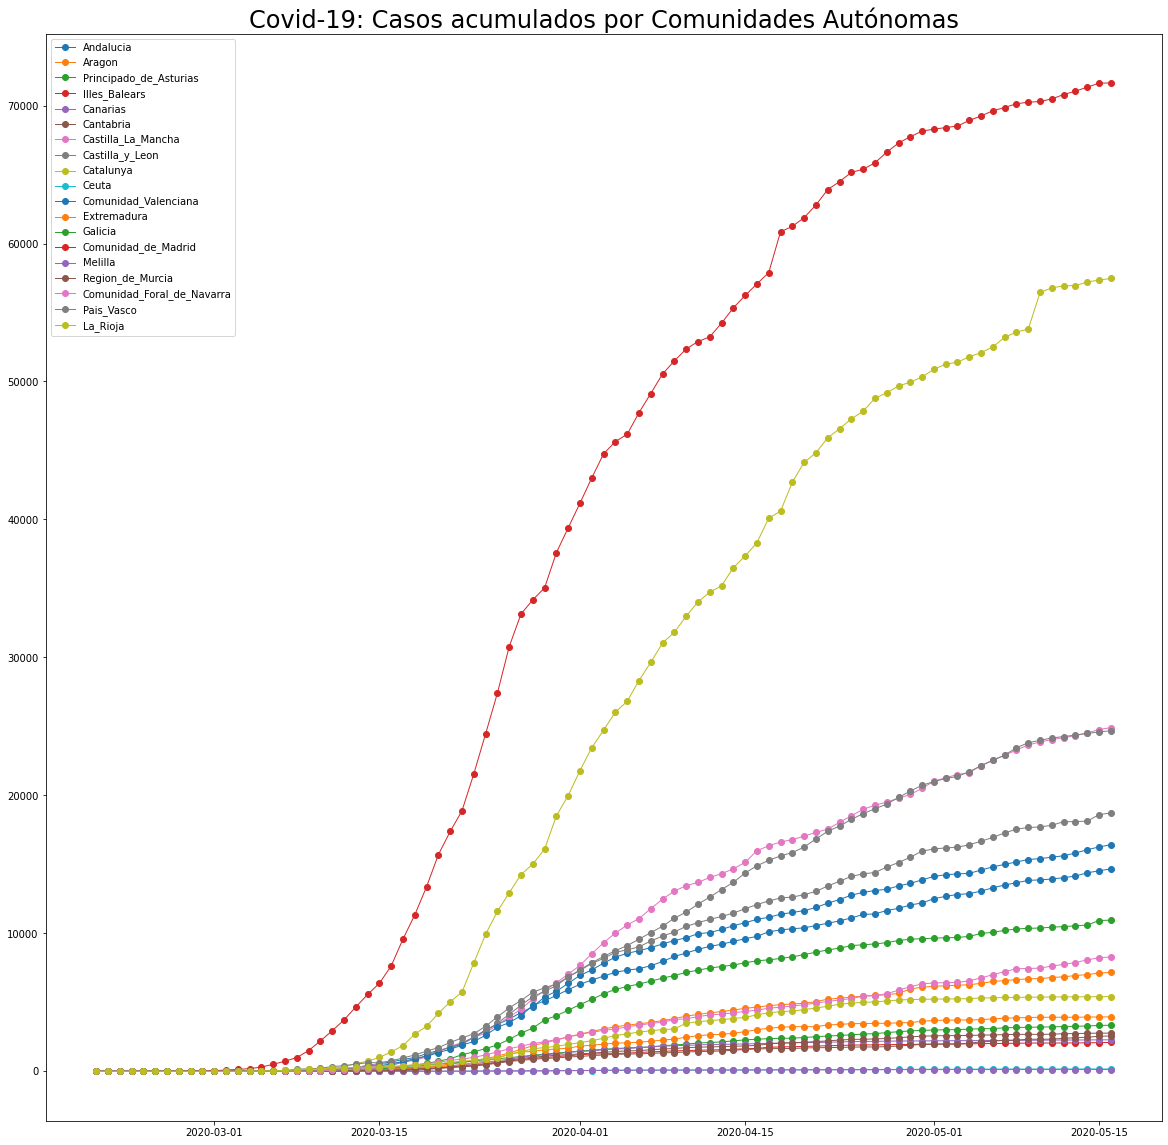

In [21]:
fig = plt.figure(figsize=(20,20))
ccaa_list = list(df_input['ccaa_name'].unique())
for v in ccaa_list:
    tmp = df_input[df_input['ccaa_name']==v]
    plt.plot(tmp['fecha'], tmp['casos'], marker='o', ls='-', lw=1, label=v)
plt.title('Covid-19: Casos acumulados por Comunidades Autónomas', fontsize=24)
plt.legend()
plt.show()

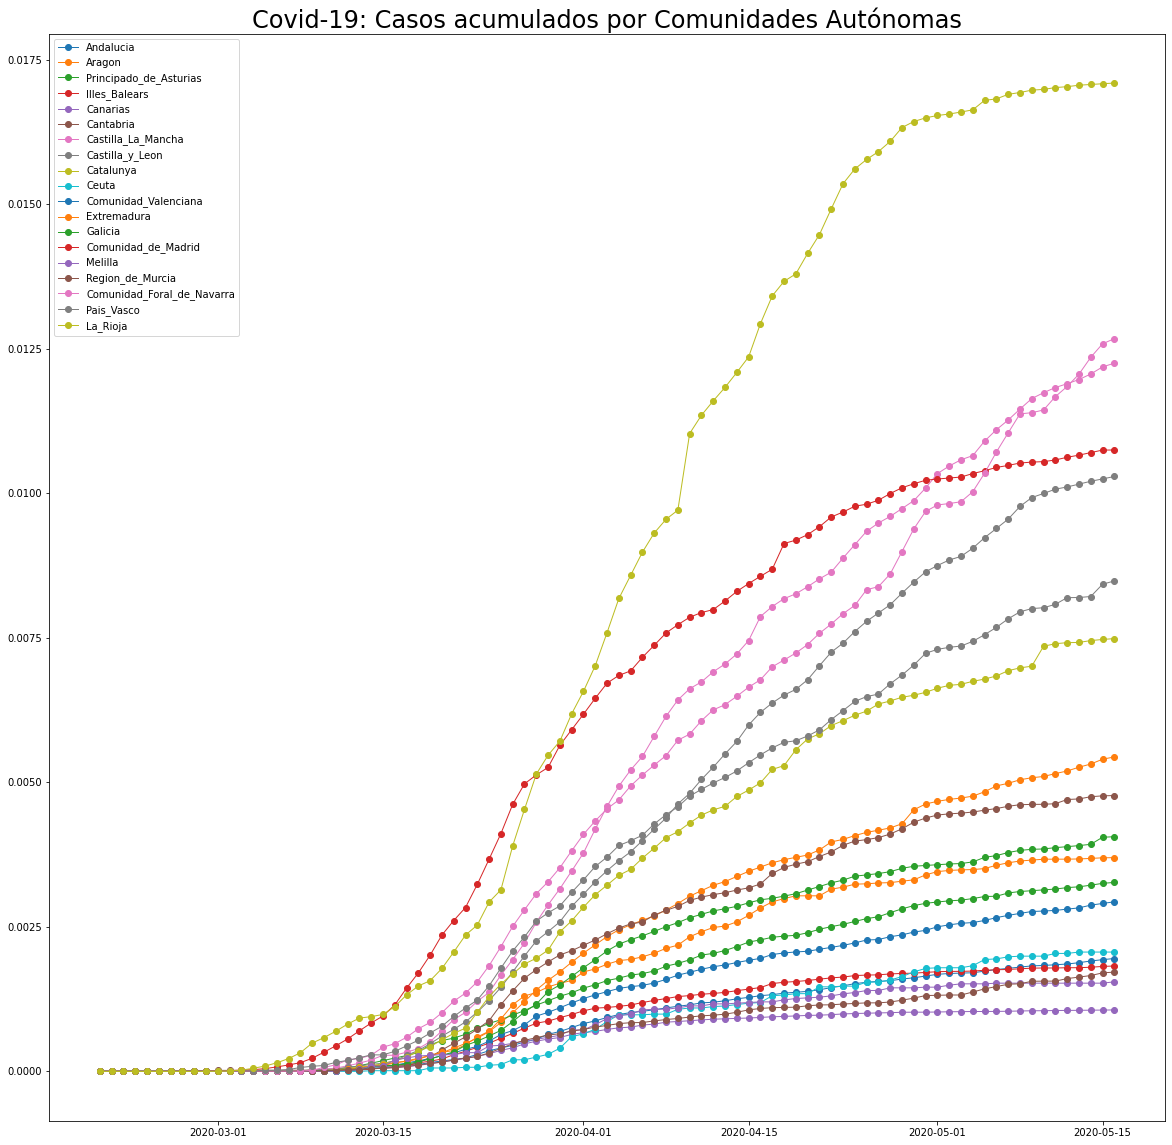

In [22]:
fig = plt.figure(figsize=(20,20))
ccaa_list = list(df_input['ccaa_name'].unique())
for v in ccaa_list:
    tmp = df_input[df_input['ccaa_name']==v]
    plt.plot(tmp['fecha'], tmp['casos']/float(df_pop[df_pop['ccaa_name']==v]['population']), marker='o', ls='-', lw=1, label=v)
plt.title('Covid-19: Casos acumulados por Comunidades Autónomas', fontsize=24)
plt.legend()
plt.show()

## Split data into: train and test

In [24]:
df_input.index = df_input['fecha']
df_train = df_input.loc['2020-03-16':'2020-04-18'][['ccaa_name','casos','fallecidos']]
print(df_train.tail())
df_test = df_input.loc['2020-04-19':][['ccaa_name','casos','fallecidos']]
print(df_test.tail())

                             ccaa_name    casos  fallecidos
fecha                                                      
2020-04-18                     Melilla    107.0         2.0
2020-04-18            Region_de_Murcia   1653.0       116.0
2020-04-18  Comunidad_Foral_de_Navarra   4656.0       369.0
2020-04-18                  Pais_Vasco  12569.0      1062.0
2020-04-18                    La_Rioja   4330.0       277.0
                             ccaa_name    casos  fallecidos
fecha                                                      
2020-05-16                     Melilla    134.0         2.0
2020-05-16            Region_de_Murcia   2566.0       144.0
2020-05-16  Comunidad_Foral_de_Navarra   8293.0       503.0
2020-05-16                  Pais_Vasco  18733.0      1459.0
2020-05-16                    La_Rioja   5417.0       349.0
